# Model Evaluation for pre-trained models
Models selected for object detection:
1. [ultralytics/yolov5](https://pytorch.org/hub/ultralytics_yolov5/) - YOLOv5s
2. [yolov11s](https://github.com/ultralytics/ultralytics).

In [30]:
from my_utils.dataset_loader import ObjectDetectionDataset, DatasetMode, simple_collate_fn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    average_precision_score, roc_auc_score,
    multilabel_confusion_matrix
)
import torchvision.ops as ops
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
data_dir = "D:\\Projects\\ml-ops-wildlife\\data\\WAID"

In [3]:
torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
test_dataset = ObjectDetectionDataset(data_dir, DatasetMode.TEST, transform=transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=simple_collate_fn)

Loading labels: 100%|██████████| 1437/1437 [00:00<00:00, 2050.75it/s]


In [5]:
model_yolov5 = torch.hub.load('ultralytics/yolov5', 'custom', path="../models/yolov5s.pt").to(device)

Using cache found in C:\Users\Mihai/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-11-15 Python-3.12.0 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12281MiB)

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [6]:
def compute_metrics(model, dataloader, conf_threshold=0.25):
    """
    Compute comprehensive metrics for YOLOv5 predictions using sklearn

    Returns:
        Dictionary containing various metrics and plots confusion matrices
    """
    model.eval()
    all_true_labels = []
    all_pred_labels = []
    all_pred_scores = []  # For AUC and mAP

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images = images.to(device)
            batch_size = images.shape[0]

            # Get predictions
            pred = model(images)

            # Process each image in batch
            for idx in range(batch_size):
                # Get predictions for single image
                single_pred = pred[idx]
                single_true_labels = torch.zeros(6)  # 6 classes
                for label in labels[idx]:
                    single_true_labels[label] = 1

                # Get confidence scores
                conf = single_pred[:, 4]

                # Get class probabilities
                class_probs = single_pred[:, 5:]  # Shape: [25200, 6]

                # Get predicted classes and their probabilities
                class_scores, class_ids = class_probs.max(1)  # highest class score and index
                final_conf = conf * class_scores

                # Filter by confidence threshold
                mask = final_conf > conf_threshold
                filtered_class_ids = class_ids[mask]

                # Get maximum probability for each class (for AUC and mAP)
                max_probs_per_class = torch.zeros(class_probs.shape[1])
                for i in range(class_probs.shape[1]):
                    class_mask = class_ids == i
                    if class_mask.any():
                        max_probs_per_class[i] = (final_conf * class_mask).max()

                # Convert predictions to binary format
                num_classes = class_probs.shape[1]
                pred_labels = torch.zeros(num_classes)

                # Mark predicted classes as 1
                for class_id in filtered_class_ids:
                    pred_labels[class_id] = 1

                # Append to overall lists
                all_true_labels.append(single_true_labels.cpu().numpy())
                all_pred_labels.append(pred_labels.cpu().numpy())
                all_pred_scores.append(max_probs_per_class.cpu().numpy())

    # Convert lists to arrays
    all_true_labels = np.array(all_true_labels)
    all_pred_labels = np.array(all_pred_labels)
    all_pred_scores = np.array(all_pred_scores)

    # Compute metrics
    metrics = {}

    # F1, Precision, Recall (per class and averaged)
    metrics['f1_per_class'] = f1_score(all_true_labels, all_pred_labels, average=None)
    metrics['precision_per_class'] = precision_score(all_true_labels, all_pred_labels, average=None)
    metrics['recall_per_class'] = recall_score(all_true_labels, all_pred_labels, average=None)

    metrics['f1_macro'] = f1_score(all_true_labels, all_pred_labels, average='macro')
    metrics['precision_macro'] = precision_score(all_true_labels, all_pred_labels, average='macro')
    metrics['recall_macro'] = recall_score(all_true_labels, all_pred_labels, average='macro')

    # mAP and AUC
    metrics['mAP_per_class'] = average_precision_score(all_true_labels, all_pred_scores, average=None)
    metrics['mAP'] = average_precision_score(all_true_labels, all_pred_scores, average='macro')

    # AUC might raise error if some classes don't have both positive and negative examples
    try:
        metrics['auc_per_class'] = roc_auc_score(all_true_labels, all_pred_scores, average=None)
        metrics['auc'] = roc_auc_score(all_true_labels, all_pred_scores, average='macro')
    except ValueError as e:
        print(f"Warning: Could not compute AUC: {e}")
        metrics['auc_per_class'] = np.array([np.nan] * all_true_labels.shape[1])
        metrics['auc'] = np.nan

    # Confusion Matrix
    metrics['confusion_matrices'] = multilabel_confusion_matrix(all_true_labels, all_pred_labels)

    # Print results
    print("\nPer-class metrics:")
    for i in range(all_true_labels.shape[1]):
        print(f"\nClass {i}:")
        print(f"F1: {metrics['f1_per_class'][i]:.4f}")
        print(f"Precision: {metrics['precision_per_class'][i]:.4f}")
        print(f"Recall: {metrics['recall_per_class'][i]:.4f}")
        print(f"mAP: {metrics['mAP_per_class'][i]:.4f}")
        print(f"AUC: {metrics['auc_per_class'][i]:.4f}")

    print("\nOverall metrics:")
    print(f"Macro F1: {metrics['f1_macro']:.4f}")
    print(f"Macro Precision: {metrics['precision_macro']:.4f}")
    print(f"Macro Recall: {metrics['recall_macro']:.4f}")
    print(f"mAP: {metrics['mAP']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

    # Plot confusion matrices
    plot_confusion_matrices(metrics['confusion_matrices'])

    return metrics

def plot_confusion_matrices(confusion_matrices):
    """
    Plot confusion matrix for each class
    """
    num_classes = len(confusion_matrices)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust layout based on number of classes
    axes = axes.ravel()

    for i in range(num_classes):
        cm = confusion_matrices[i]
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'Class {i}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

In [7]:
metrics = compute_metrics(
    model=model_yolov5,
    dataloader=test_dataloader,
    conf_threshold=0.25
)


Per-class metrics:

Class 0:
F1: 0.9812
Precision: 0.9789
Recall: 0.9835
mAP: 0.9991
AUC: 0.9996

Class 1:
F1: 0.9549
Precision: 0.9137
Recall: 1.0000
mAP: 0.9996
AUC: 0.9998

Class 2:
F1: 0.9969
Precision: 0.9938
Recall: 1.0000
mAP: 1.0000
AUC: 1.0000

Class 3:
F1: 0.6441
Precision: 0.4935
Recall: 0.9268
mAP: 0.7606
AUC: 0.9803

Class 4:
F1: 0.6847
Precision: 0.5390
Recall: 0.9383
mAP: 0.7440
AUC: 0.9821

Class 5:
F1: 0.7812
Precision: 0.7463
Recall: 0.8197
mAP: 0.9122
AUC: 0.9933

Overall metrics:
Macro F1: 0.8405
Macro Precision: 0.7775
Macro Recall: 0.9447
mAP: 0.9026
AUC: 0.9925


## Surprise error
RuntimeError: stack expects each tensor to be equal size, but got [3, 640, 640] at entry 0 and [3, 500, 500] at entry 14
```
for i in range(len(dataset)):
    assert dataset[i][0].shape == torch.Size([3, 640, 640]), f"Error at index {i}"
```
Using the code above, I've discovered that the image sizes are not consistent. I'll need to resize the images to a common size before passing them to the model.

Loading labels: 100%|██████████| 1437/1437 [00:00<00:00, 4955.81it/s]


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2]
[3, 3, 3, 3, 3, 3, 3]
[5, 5, 5]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


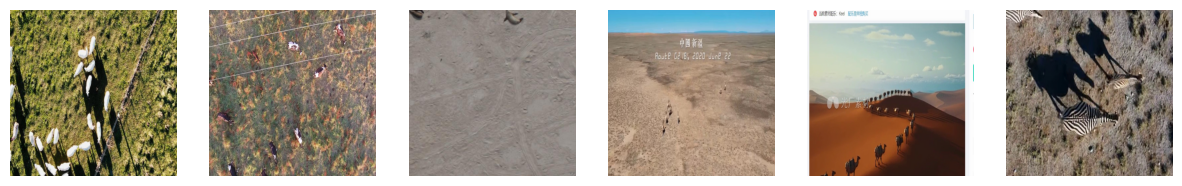

In [19]:
# let's pick a few random images and see how they look
%matplotlib inline
local_dataset = ObjectDetectionDataset(data_dir, DatasetMode.TEST, transform=None)

images = {}

for image, label, bbox in local_dataset:
    if label[0] not in images:
        images[label[0]] = (image, label, bbox)

fig, axes = plt.subplots(1, 6, figsize=(15, 5))
axes = axes.ravel()

for i, (image, label, bbox) in images.items():
    print(label)
    axes[int(i)].imshow(image)
    axes[int(i)].axis('off')

# use matplotlib to show the images
plt.show()

Predicted classes: ['cattle']. Original classes: ['cattle']


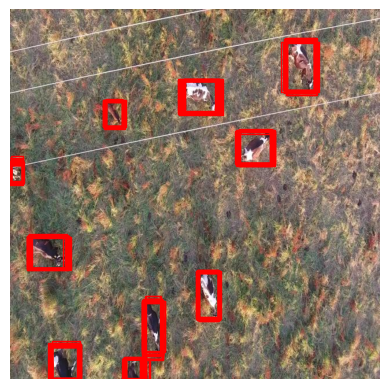

Predicted classes: ['seal']. Original classes: ['seal']


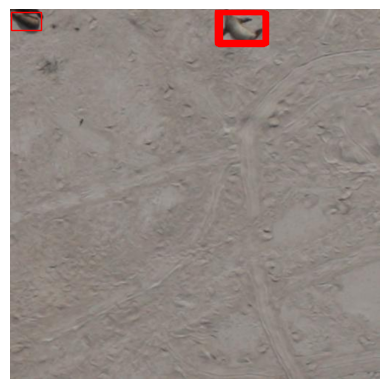

Predicted classes: ['camelus', 'kiang']. Original classes: ['camelus']


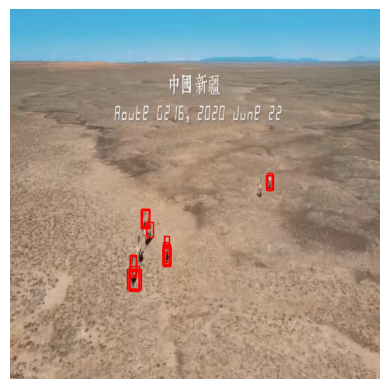

Predicted classes: ['zebra']. Original classes: ['zebra']


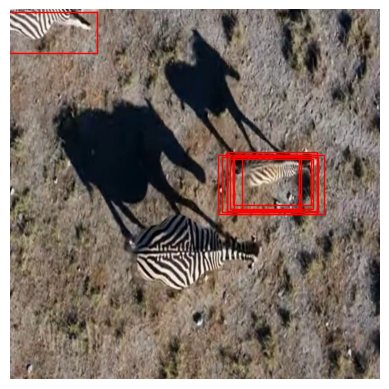

Predicted classes: ['camelus', 'kiang']. Original classes: ['kiang']


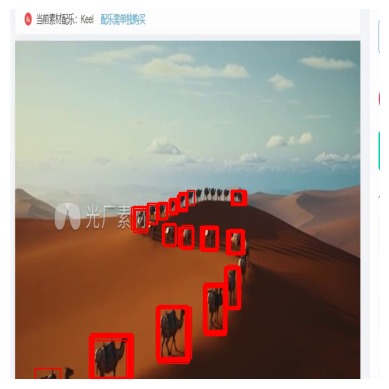

Predicted classes: ['sheep']. Original classes: ['sheep']


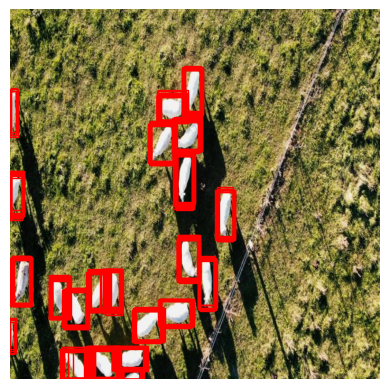

In [40]:
# let's predict on the images
model_yolov5.eval()
model_yolov5 = model_yolov5.to(device)

for i, (image, label, bbox) in images.items():
    image = transforms.ToTensor()(image).unsqueeze(0).to(device)
    pred = model_yolov5(image)

    # extract class and bbox
    class_probs = pred[0][:, 5:]
    conf = pred[0][:, 4]
    class_scores, class_ids = class_probs.max(1)
    final_conf = conf * class_scores

    # Filter by confidence threshold
    mask = final_conf > 0.25
    filtered_class_ids = class_ids[mask]
    filtered_conf = final_conf[mask]

    # get bounding boxes
    bboxes = pred[0][:, :4][mask]

    # Apply NMS for each class separately
    keep_indices = ops.nms(
        boxes=bboxes,
        scores=filtered_conf,
        iou_threshold=0.25  # Adjust this threshold as needed
    )

    # Get final predictions after NMS
    final_boxes = bboxes[keep_indices].cpu().numpy()
    final_classes = filtered_class_ids[keep_indices].cpu().numpy()
    final_scores = filtered_conf[keep_indices].cpu().numpy()

    predicted_classes = []
    original_classes = []
    for class_id in set(final_classes):
        predicted_classes.append(local_dataset.classes[class_id])
    for class_id in set(label):
        original_classes.append(local_dataset.classes[class_id])

    print(f"Predicted classes: {predicted_classes}. Original classes: {original_classes}")

    # Plot results
    fig, ax = plt.subplots()
    ax.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))

    for box, cls, score in zip(final_boxes, final_classes, final_scores):
        x_center, y_center, width, height = box
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        rect = plt.Rectangle((x1, y1), width, height, fill=False, color="red")
        ax.add_patch(rect)
        # Optionally add class label and score
        # ax.text(x1, y1, f'Class {cls}: {score:.2f}',
        #         bbox=dict(facecolor='white', alpha=0.7))

    plt.axis('off')
    plt.show()

In [42]:
from ultralytics import YOLO

# Load a model
model = YOLO("D:\\Projects\\ml-ops-wildlife\\runs\\detect\\yolo11s\\weights\\best.pt")  # pretrained YOLO11n model

# Run batched inference on a list of images
results = model([image for image, _, _ in images.values()])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen


0: 640x640 11 cattles, 52.6ms
1: 640x640 3 seals, 52.6ms
2: 640x640 9 cameluss, 52.6ms
3: 640x640 2 zebras, 52.6ms
4: 640x640 34 kiangs, 52.6ms
5: 640x640 22 sheeps, 52.6ms
Speed: 2.0ms preprocess, 52.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
